# **Classification naïve bayésienne sur les avis AlloCiné de la  série télévisée Lupin (2021)**

***
**Table des matières :**
* [1. Importation des modules](#1)
* [2. Importation et aperçu des données](#2)
  * [2.1 Vue d'ensemble](#21)
  * [2.2 Répartition des notes](#22)
  * [2.3 Moyenne de mots par avis](#23)
* [3. Préparation des données](#3)
* [4. Prédiction naïve basée sur les mots de négation](#4)
  * [4.1 Prépossessing des données](#41)
  * [4.2 Modélisation arbitraire par les mots de négation](#42)
  * [4.3 Matrice de confusion et interprétation du résultat](#43)
* [5. Classification naïve bayesienne sur une cible binaire](#5)
  * [5.1 Prépossessing des données](#51)
  * [5.2 Modélisation par BernoulliNB](#52)
  * [5.3 Matrice de confusion et interprétation du résultat](#53)
* [6. Classification naïve bayesienne sur les multi-cibles](#6)
  * [6.1 Prépossessing des données](#61)
  * [6.2 Modélisation par MultinomialNB](#62)
  * [6.3 Matrice de confusion et interprétation du résultat](#63)
***

**Étudiant :**
- Zhifeng LIANG

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<a id='1'></a>
## **1. Importation des modules**

In [ ]:
import re
import string
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download(['punkt','stopwords'])
import spacy
spacy.cli.download('fr_core_news_md')
nlp_fr = spacy.load('fr_core_news_md')
import matplotlib.pyplot as plt
# https://spacy.io/api/annotation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

<a id='2'></a>
## **2. Importation et aperçu des données**

<a id='21'></a>
### **2.1 Vue d'ensemble**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Cours_HETIC/NLP/avis_lupin/allocine_lupin_avis2.csv')

In [ ]:
df.shape

(951, 3)

In [ ]:
df.sample(5)

,Note,Description,key
39,"5,0",Omar Sy nous surprend une nouvelle fois dans c...,9
835,"4,0",Sympathique ! Certes le jeu d'acteur n'est pas...,10
834,"4,0","J'ai regardé la série sans a apriori, sans avo...",9
415,"4,5",Franchement les critiques négatives sont dures...,10
892,"5,0","Super serie! Je me suis prise au jeu, et j’ai ...",7


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Note         951 non-null    object
 1   Description  951 non-null    object
 2   key          951 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 22.4+ KB


<a id='22'></a>
### **2.2 Répartition des notes**

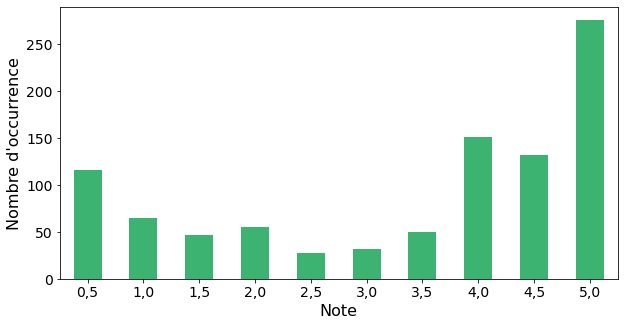

In [ ]:
plt.figure(figsize=(10,5))
df['Note'].value_counts().sort_index().plot(kind='bar', color='mediumseagreen')
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Note', fontsize=16)
plt.ylabel('Nombre d\'occurrence', fontsize=16)
plt.show()

<a id='23'></a>
### **2.3 Moyenne de mots par avis**

In [ ]:
np.round(np.mean((df['Description'].apply(lambda x: len(x.split(' '))))))

64.0

<a id='3'></a>
## **3. Préparation des données**

- Suppression de la colonne **key** qui servait de la pagination de la source.
- Suppression des 143 lignes dupliquées
- Réassignation des indices
- Transformation du type du contenu de la colonne **Note** de `string` en `float`.

In [ ]:
df = df.drop(columns='key', axis=1)

In [ ]:
sum(df['Description'].duplicated())

143

In [ ]:
df = df.drop_duplicates(subset=['Description'])
df = df.reset_index(drop=True)
df.shape

(808, 2)

In [ ]:
df['Note'] = df['Note'].apply(lambda x: float(x.replace(',', '.')))

<a id='4'></a>
## **4. Prédiction naïve basée sur les mots de négation**

<a id='41'></a>
### **4.1 Prépossessing des données**

- Suppression des stopwords, sauf les mots de négation
- Tokenisation des phrases
- Lemmatisation des tokens

In [ ]:
stop_words_fr = set(stopwords.words('french') + ['euro', 'euros', 'eur', 'km'] + list(string.ascii_lowercase))

In [ ]:
stop_words_fr_without_negation = stop_words_fr - set(('ne', 'pas', 'mais'))

In [ ]:
df['Tokens_with_negation'] = df['Description'] \
.apply(lambda x: re.sub(r'[^\w\s]',' ', x)) \
.apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words_fr_without_negation]) \
.apply(lambda x: [word.lemma_ for word in nlp_fr(' '.join(x))])

- Transformation de classification multiple en classification binaire en regroupant les 10 notes en 2 groupes :
  - Note $\geq$ 3 $=>$ avis positifs; Note $<$ 3 $=>$ avis négatifs.

In [ ]:
df['Note_binary'] = df['Note'].apply(lambda x: 1 if x >= 3 else 0)

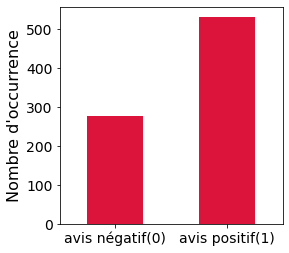

In [ ]:
plt.figure(figsize=(4,4))
df['Note_binary'].value_counts().sort_index().plot(kind='bar', color='crimson')
plt.xticks(range(2), ['avis négatif(0)', 'avis positif(1)'], rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Nombre d\'occurrence', fontsize=16)
plt.show()

<a id='42'></a>
### **4.2 Modélisation arbitraire par les mots de négation**

In [ ]:
df['Naive_prediction'] = df['Description'].apply(lambda x: 0 if any(e in x for e in ['ne', 'pas', 'mais', 'ni', 'jamais', 'guère', 'rien']) else 1)

<a id='43'></a>
### **4.3 Matrice de confusion et interprétation du résultat**

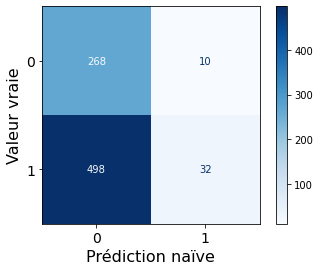

In [ ]:
cm_naive = confusion_matrix(df['Note_binary'], df['Naive_prediction'])
disp_naive = ConfusionMatrixDisplay(confusion_matrix=cm_naive, display_labels=[str(i) for i in range(2)])
disp_naive.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=0, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.xlabel('Prédiction naïve', fontsize=16)
plt.ylabel('Valeur vraie', fontsize=16)
plt.show()

In [ ]:
print(classification_report(df['Note_binary'], df['Naive_prediction']))

              precision    recall  f1-score   support

           0       0.35      0.96      0.51       278
           1       0.76      0.06      0.11       530

    accuracy                           0.37       808
   macro avg       0.56      0.51      0.31       808
weighted avg       0.62      0.37      0.25       808



- Accuracy : globalement, 37% des cas sont correctement prédits.
- Précision : Parmi les avis qui sont prédits positifs, 76% sont corrects.  
- Rappel : Parmi les avis qui sont réllement positifs, 6% sont correctement prédicts.
- F-measure : 11%, la moyenne harmonique de la Précision et du Rappel.

<a id='5'></a>
## **5. Classification naïve bayesienne sur une cible binaire**

<a id='51'></a>
### **5.1 Prépossessing des données**

- Suppression des stopwords, incluant les mots de négation
- Tokenisation des phrases
- Lemmatisation des tokens
- Séparation des données en train et test
- Vectorisation des données par `CountVectorizer`

In [ ]:
df['Tokens'] = df['Description'] \
.apply(lambda x: re.sub(r'[^\w\s]',' ', x)) \
.apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words_fr]) \
.apply(lambda x: [word.lemma_ for word in nlp_fr(' '.join(x))])

In [ ]:
X_train, X_test, y_bi_train, y_bi_test = train_test_split(df['Tokens'].apply(lambda x: ' '.join(x)), df['Note_binary'], test_size=0.2, random_state=33)

In [ ]:
count_vectorizer = CountVectorizer()
X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)

<a id='52'></a>
### **5.2 Modélisation par `BernoulliNB`**

In [ ]:
clf_bernoulliNb = BernoulliNB()
clf_bernoulliNb.fit(X_train_cv, y_bi_train)
y_bi_pred = clf_bernoulliNb.predict(X_test_cv)

<a id='53'></a>
### **5.3 Matrice de confusion et interprétation du résultat**

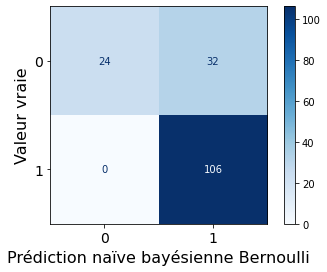

In [ ]:
cm_bernoulliNb = confusion_matrix(y_bi_test, y_bi_pred)
disp_bernoulliNb = ConfusionMatrixDisplay(confusion_matrix=cm_bernoulliNb, display_labels=[str(i) for i in range(2)])
disp_bernoulliNb.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=0, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.xlabel('Prédiction naïve bayésienne Bernoulli', fontsize=16)
plt.ylabel('Valeur vraie', fontsize=16)
plt.show()

In [ ]:
print(classification_report(y_bi_test, y_bi_pred))

              precision    recall  f1-score   support

           0       1.00      0.43      0.60        56
           1       0.77      1.00      0.87       106

    accuracy                           0.80       162
   macro avg       0.88      0.71      0.73       162
weighted avg       0.85      0.80      0.78       162



- Accuracy : globalement, 80% des cas sont correctement prédits.
- Précision : Parmi les avis qui sont prédits positifs, 77% sont corrects. 
- Rappel : Parmi les avis qui sont réllement positifs, 100% sont correctement prédits. 
- F-measure : 87%, la moyenne harmonique de la Précision et du Rappel.

<a id='6'></a>
## **6. Classification naïve bayesienne sur les multi-cibles**

<a id='61'></a>
### **6.1 Prépossessing des données**

- Séparation des données en train et test
- Vectorisation des données par `CountVectorizer`

In [ ]:
X_train, X_test, y_multi_train, y_multi_test = train_test_split(df['Tokens'].apply(lambda x: ' '.join(x)), df['Note'].apply(lambda x: int(x*2)), test_size=0.2, random_state=33)

<a id='62'></a>
### **6.2 Modélisation par `MultinomialNB`**

In [ ]:
clf_multiNb = MultinomialNB()
clf_bernoulliNb.fit(X_train_cv, y_multi_train)
y_multi_pred = clf_bernoulliNb.predict(X_test_cv)

<a id='63'></a>
### **6.3 Matrice de confusion et interprétation du résultat**

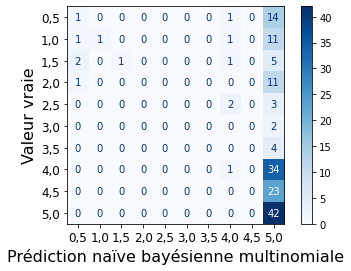

In [ ]:
cm_multiNb = confusion_matrix(y_multi_test, y_multi_pred)
disp_multiNb = ConfusionMatrixDisplay(confusion_matrix=cm_multiNb, display_labels=[str(float(i/2)).replace('.', ',') for i in range(1, 11)])
disp_multiNb.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.xlabel('Prédiction naïve bayésienne multinomiale', fontsize=16)
plt.ylabel('Valeur vraie', fontsize=16)
plt.show()

In [ ]:
print(classification_report(y_multi_test, y_multi_pred))

              precision    recall  f1-score   support

           1       0.20      0.06      0.10        16
           2       1.00      0.07      0.13        14
           3       1.00      0.11      0.20         9
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         4
           8       0.17      0.03      0.05        35
           9       0.00      0.00      0.00        23
          10       0.28      1.00      0.44        42

    accuracy                           0.28       162
   macro avg       0.26      0.13      0.09       162
weighted avg       0.27      0.28      0.16       162



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Accuracy : globalement, 28% des cas sont correctement prédits.
- Précision : Parmi les avis dont la note est predict qu'est 1,0 ou 1,5, 100% sont corrects; environ 20-30% pour ceux dont la note est predict qu'est 0,5 ou 4,0 ou 5,0. 
- Rappel : Parmi les avis dont la note est réllement 5,0, 100% sont correctement prédits; environ 11% pour ceux dont la note est 1,5.
- F-measure : la moyenne harmonique de la Précision et du Rappel, 44% pour les avis dont la note est 5,0, 10-20% pour ceux dont la note est 0,5 ou 1,0 ou 1,5.

In [ ]:
clf_gaussianNb = GaussianNB()
clf_gaussianNb.fit(X_train_cv.toarray(), y_multi_train)
y_gauss_pred = clf_gaussianNb.predict(X_test_cv.toarray())

In [ ]:
print(classification_report(y_multi_test, y_gauss_pred))

              precision    recall  f1-score   support

           1       0.35      0.50      0.41        16
           2       0.20      0.14      0.17        14
           3       0.18      0.22      0.20         9
           4       0.50      0.17      0.25        12
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         4
           8       0.36      0.34      0.35        35
           9       0.50      0.43      0.47        23
          10       0.57      0.55      0.56        42

    accuracy                           0.36       162
   macro avg       0.27      0.24      0.24       162
weighted avg       0.40      0.36      0.37       162



In [ ]:
df['Note_binary_int'] = df['Note'].apply(lambda x: 3 if int(x) <= 3 else int(x))

In [ ]:
X_train, X_test, y_multi_int_train, y_multi_int_test = train_test_split(df['Tokens'].apply(lambda x: ' '.join(x)), df['Note_binary_int'], test_size=0.2, random_state=33)

In [ ]:
clf_multiNb = MultinomialNB()
clf_bernoulliNb.fit(X_train_cv, y_multi_int_train)
y_multi_int_pred = clf_bernoulliNb.predict(X_test_cv)

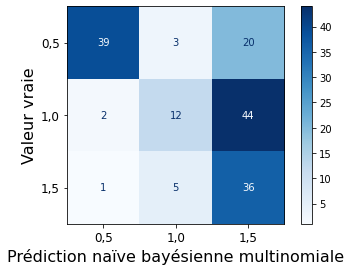

In [ ]:
cm_multiNb = confusion_matrix(y_multi_int_test, y_multi_int_pred)
disp_multiNb = ConfusionMatrixDisplay(confusion_matrix=cm_multiNb, display_labels=[str(float(i/2)).replace('.', ',') for i in range(1, 11)])
disp_multiNb.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.xlabel('Prédiction naïve bayésienne multinomiale', fontsize=16)
plt.ylabel('Valeur vraie', fontsize=16)
plt.show()

In [ ]:
print(classification_report(y_multi_int_test, y_multi_int_pred))

              precision    recall  f1-score   support

           3       0.93      0.63      0.75        62
           4       0.60      0.21      0.31        58
           5       0.36      0.86      0.51        42

    accuracy                           0.54       162
   macro avg       0.63      0.56      0.52       162
weighted avg       0.66      0.54      0.53       162

